# Лабораторная работа 4: Постановка экспериментов для модели билетных касс

В этом ноутбуке используется имитационная модель билетных касс с перерывами (из ЛР2/ЛР3),
и по аналогии с примером `Lab4-1/lab4.py` выполняются эксперименты:

1. Зависимость отклика (среднего времени ожидания) от варьируемого параметра (интенсивность прибытия).
2. Анализ отказа ресурсов (уменьшение числа работающих касс) и устойчивости системы.
3. Сравнение альтернативных организационных решений (разное число касс, скорость обслуживания, поток).
4. Двухфакторный эксперимент (число касс и интенсивность потока) и анализ значимости факторов.


In [1]:
# Импорт библиотек и базовые константы

import heapq
import random
import math
from dataclasses import dataclass, field
from typing import Callable, List, Optional, Dict, Tuple, Any

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit

MINUTES = 1.0
HOUR = 60.0 * MINUTES

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (12, 6)

print("Импорт выполнен, константы заданы")


Импорт выполнен, константы заданы


In [2]:
# Модель билетных касс (из ЛР2/ЛР3)

@dataclass
class Passenger:
    id: int
    arrival_time: float
    chosen_booth_id: Optional[int] = None
    service_start_time: Optional[float] = None
    service_end_time: Optional[float] = None
    abandoned: bool = False
    waited_over_break: bool = False


@dataclass(order=True)
class Event:
    time: float
    priority: int
    kind: str
    payload: Any = field(compare=False, default=None)


class DES:
    def __init__(self):
        self.t: float = 0.0
        self.queue: List[Event] = []
        self.event_counter: int = 0

    def schedule(self, time: float, kind: str, payload: Any = None, priority: int = 0):
        self.event_counter += 1
        evt = Event(time=time, priority=priority, kind=kind, payload=payload)
        heapq.heappush(self.queue, evt)

    def run(self, until: float, on_event: Callable[[Event, float], None]):
        while self.queue and self.queue[0].time <= until:
            evt = heapq.heappop(self.queue)
            self.t = evt.time
            on_event(evt, self.t)
        self.t = until


class TicketBooth:
    def __init__(self, booth_id: int, params: Dict[str, Any]):
        self.booth_id = booth_id
        self.params = params
        self.queue: List[Passenger] = []
        self.is_on_break: bool = False
        self.is_in_announce: bool = False
        self.cycle_start_time: float = 0.0
        self.currently_serving: Optional[Passenger] = None
        self.next_cycle_break_start: float = 0.0
        self.next_cycle_break_end: float = 0.0
        self.next_announce_time: float = 0.0

    def perceived_queue_length(self) -> int:
        penalty = self.params["announce_penalty"] if self.is_in_announce else 0
        if self.is_on_break:
            return 10**9
        return len(self.queue) + penalty

    def plan_cycle(self, now: float) -> Tuple[float, float, float]:
        work = self.params["work_minutes"]
        brk = self.params["break_minutes"]
        announce = self.params["announce_minutes"]
        start = now
        break_start = start + work
        break_end = break_start + brk
        announce_time = max(start, break_start - announce)
        self.cycle_start_time = start
        self.next_cycle_break_start = break_start
        self.next_cycle_break_end = break_end
        self.next_announce_time = announce_time
        return announce_time, break_start, break_end

    def on_announce(self):
        self.is_in_announce = True

    def on_break_start(self):
        self.is_on_break = True
        self.is_in_announce = False

    def on_break_end(self, new_cycle_start: float):
        self.is_on_break = False
        self.is_in_announce = False
        self.cycle_start_time = new_cycle_start


class Metrics:
    def __init__(self, num_booths: int):
        self.num_booths = num_booths
        self.total_wait_time: float = 0.0
        self.total_system_time: float = 0.0
        self.num_completed: int = 0
        self.num_abandoned: int = 0
        self.num_waited_over_break: int = 0
        self.queue_area: List[float] = [0.0 for _ in range(num_booths)]
        self.last_queue_time: float = 0.0

    def accumulate_queue_lengths(self, booths: List[TicketBooth], now: float):
        dt = now - self.last_queue_time
        if dt < 0:
            return
        for i, booth in enumerate(booths):
            self.queue_area[i] += len(booth.queue) * dt
        self.last_queue_time = now

    def record_service_completion(self, p: Passenger):
        if p.service_start_time is not None:
            self.total_wait_time += (p.service_start_time - p.arrival_time)
        if p.service_end_time is not None:
            self.total_system_time += (p.service_end_time - p.arrival_time)
        self.num_completed += 1

    def record_abandon(self):
        self.num_abandoned += 1

    def record_waited_over_break(self):
        self.num_waited_over_break += 1


def expovariate(rate: float) -> float:
    u = random.random()
    return -math.log(1.0 - u) / rate


class BusStationModel:
    def __init__(self, params: Dict[str, Any]):
        self.params = params
        self.des = DES()
        self.booths: List[TicketBooth] = [TicketBooth(i, params) for i in range(params["num_booths"])]
        self.metrics = Metrics(params["num_booths"])
        self.now = 0.0
        self.next_passenger_id = 0

    def initialize(self):
        self.now = 0.0
        self.metrics.last_queue_time = 0.0
        for booth in self.booths:
            announce_time, break_start, break_end = booth.plan_cycle(self.now)
            self.des.schedule(announce_time, kind="announce", payload={"booth": booth.booth_id})
            self.des.schedule(break_start, kind="break_start", payload={"booth": booth.booth_id})
            self.des.schedule(break_end, kind="break_end", payload={"booth": booth.booth_id})
        ia = expovariate(self.params["arrival_rate"]) if self.params["arrival_rate"] > 0 else float("inf")
        self.des.schedule(self.now + ia, kind="arrival")

    def choose_booth_for_passenger(self) -> int:
        delta = self.params["approx_delta"]
        epsilon = self.params["epsilon_random"]
        perceived = [(booth.perceived_queue_length(), booth.booth_id) for booth in self.booths]
        perceived.sort()
        min_len = perceived[0][0]
        candidates = [bid for (l, bid) in perceived if l <= min_len + delta]
        if random.random() < epsilon:
            return random.choice([b.booth_id for b in self.booths])
        return random.choice(candidates)

    def handle_event(self, evt: Event, now: float):
        self.metrics.accumulate_queue_lengths(self.booths, now)
        self.now = now
        kind = evt.kind
        payload = evt.payload or {}
        if kind == "arrival":
            self.on_arrival()
        elif kind == "service_end":
            self.on_service_end(payload["booth"], payload["passenger"])
        elif kind == "announce":
            self.on_announce(payload["booth"])
        elif kind == "break_start":
            self.on_break_start(payload["booth"])
        elif kind == "break_end":
            self.on_break_end(payload["booth"])

    def on_arrival(self):
        p = Passenger(id=self.next_passenger_id, arrival_time=self.now)
        self.next_passenger_id += 1
        booth_id = self.choose_booth_for_passenger()
        p.chosen_booth_id = booth_id
        booth = self.booths[booth_id]
        max_wait = self.params["max_wait_time"]
        if max_wait is not None and booth.is_on_break:
            time_until_end = booth.next_cycle_break_end - self.now
            if time_until_end > max_wait:
                p.abandoned = True
                self.metrics.record_abandon()
            else:
                booth.queue.append(p)
        else:
            booth.queue.append(p)
        if not booth.is_on_break and booth.currently_serving is None and booth.queue:
            self.start_service(booth)
        ia = expovariate(self.params["arrival_rate"]) if self.params["arrival_rate"] > 0 else float("inf")
        next_t = self.now + ia
        if next_t <= self.params["simulation_duration"]:
            self.des.schedule(next_t, kind="arrival")

    def start_service(self, booth: TicketBooth):
        if booth.is_on_break or not booth.queue:
            return
        p = booth.queue.pop(0)
        booth.currently_serving = p
        p.service_start_time = self.now
        service_time = expovariate(self.params["service_rate_per_booth"]) if self.params["service_rate_per_booth"] > 0 else float("inf")
        end_time = self.now + service_time
        if end_time > booth.next_cycle_break_start and not booth.is_on_break:
            time_before_break = booth.next_cycle_break_start - self.now
            remaining = service_time - max(0.0, time_before_break)
            p.waited_over_break = True
            self.metrics.record_waited_over_break()
            end_time = booth.next_cycle_break_end + remaining
        self.des.schedule(end_time, kind="service_end", payload={"booth": booth.booth_id, "passenger": p})

    def on_service_end(self, booth_id: int, p: Passenger):
        booth = self.booths[booth_id]
        booth.currently_serving = None
        p.service_end_time = self.now
        self.metrics.record_service_completion(p)
        if not booth.is_on_break and booth.queue:
            self.start_service(booth)

    def on_announce(self, booth_id: int):
        booth = self.booths[booth_id]
        booth.on_announce()
        migrate_prob = self.params["announce_migrate_prob"]
        if migrate_prob <= 0 or not booth.queue:
            return
        remaining_queue = []
        for p in booth.queue:
            if random.random() < migrate_prob:
                new_booth_id = self.choose_booth_for_passenger()
                if new_booth_id != booth_id:
                    self.booths[new_booth_id].queue.append(p)
                    continue
            remaining_queue.append(p)
        booth.queue = remaining_queue
        if not booth.is_on_break and booth.currently_serving is None and booth.queue:
            self.start_service(booth)

    def on_break_start(self, booth_id: int):
        booth = self.booths[booth_id]
        booth.on_break_start()

    def on_break_end(self, booth_id: int):
        booth = self.booths[booth_id]
        booth.on_break_end(new_cycle_start=self.now)
        announce_time, break_start, break_end = booth.plan_cycle(self.now)
        self.des.schedule(announce_time, kind="announce", payload={"booth": booth.booth_id})
        self.des.schedule(break_start, kind="break_start", payload={"booth": booth.booth_id})
        self.des.schedule(break_end, kind="break_end", payload={"booth": booth.booth_id})
        if booth.queue and booth.currently_serving is None:
            self.start_service(booth)

    def run(self):
        self.initialize()
        self.des.run(until=self.params["simulation_duration"], on_event=self.handle_event)
        self.metrics.accumulate_queue_lengths(self.booths, self.params["simulation_duration"])


def compute_results(model: BusStationModel) -> Dict[str, Any]:
    m = model.metrics
    sim_time = model.params["simulation_duration"]
    avg_wait = (m.total_wait_time / m.num_completed) if m.num_completed > 0 else 0.0
    avg_system = (m.total_system_time / m.num_completed) if m.num_completed > 0 else 0.0
    avg_queue_lengths = [area / sim_time for area in m.queue_area]
    return {
        "avg_wait_time": avg_wait,
        "avg_system_time": avg_system,
        "avg_queue_lengths": avg_queue_lengths,
        "num_waited_over_break": m.num_waited_over_break,
        "num_completed": m.num_completed,
        "num_abandoned": m.num_abandoned,
    }


def run_replications(n: int, params: Dict[str, Any], seed: int = 42) -> List[Dict[str, Any]]:
    results = []
    for i in range(n):
        random.seed(seed + i)
        m = BusStationModel(params)
        m.run()
        res = compute_results(m)
        results.append(res)
    return results

print("Модель билетных касс определена")


Модель билетных касс определена


In [3]:
# Контроллер экспериментов (полная версия как в Lab4-1, но для билетных касс)

class ExperimentController:
    """Контроллер для проведения экспериментов над моделью билетных касс"""

    def __init__(self):
        # Базовые параметры — те же, что использовались в ЛР2/ЛР3
        self.base_params: Dict[str, Any] = {
            "arrival_rate": 1.0,
            "service_rate_per_booth": 0.35,
            "num_booths": 4,
            "work_minutes": 45.0,
            "break_minutes": 15.0,
            "announce_minutes": 5.0,
            "simulation_duration": 8 * HOUR,
            "approx_delta": 1,
            "epsilon_random": 0.05,
            "announce_migrate_prob": 1.0,
            "announce_penalty": 2,
            "max_wait_time": None,
        }

    # ---------- Задача 1 ----------
    def task1_parameter_variation(self):
        """Задача 1: зависимость среднего времени ожидания от интенсивности прибытия"""
        print("=" * 80)
        print("ЗАДАЧА 1: ЗАВИСИМОСТЬ ОТКЛИКА ОТ ПАРАМЕТРА (arrival_rate)")
        print("=" * 80)

        arrival_rates = np.linspace(0.4, 1.6, 7)
        avg_wait_times: List[float] = []
        avg_queue_lengths: List[float] = []

        print("Варьирование интенсивности прибытия:")
        for rate in arrival_rates:
            params = self.base_params.copy()
            params["arrival_rate"] = rate

            results = run_replications(5, params)
            waits = [r["avg_wait_time"] for r in results if r["avg_wait_time"] > 0]
            queues = [np.mean(r["avg_queue_lengths"]) for r in results]

            avg_wait = float(np.mean(waits)) if waits else 0.0
            avg_queue = float(np.mean(queues)) if queues else 0.0

            avg_wait_times.append(avg_wait)
            avg_queue_lengths.append(avg_queue)
            print(f"  arrival_rate={rate:.2f}: ожидание={avg_wait:.2f}, очередь={avg_queue:.2f}")

        # Удаляем нули перед аппроксимацией
        valid_idx = [i for i, x in enumerate(avg_wait_times) if x > 0]
        if len(valid_idx) < 3:
            print("Недостаточно данных для надёжной аппроксимации.")
            return arrival_rates, avg_wait_times, "Недостаточно данных"

        x_valid = np.array([arrival_rates[i] for i in valid_idx])
        y_valid = np.array([avg_wait_times[i] for i in valid_idx])

        # Линейная модель
        try:
            lin_coeffs = np.polyfit(x_valid, y_valid, 1)
            lin_func = np.poly1d(lin_coeffs)
            y_lin = lin_func(x_valid)
        except Exception:
            lin_func = None
            y_lin = y_valid

        # Квадратичная модель
        try:
            quad_coeffs = np.polyfit(x_valid, y_valid, 2)
            quad_func = np.poly1d(quad_coeffs)
            y_quad = quad_func(x_valid)
        except Exception:
            quad_func = None
            y_quad = y_valid

        # Экспоненциальная модель
        def exp_func(x, a, b, c):
            return a * np.exp(b * x) + c

        try:
            exp_coeffs, _ = curve_fit(exp_func, x_valid, y_valid, p0=[1.0, 0.1, 1.0], maxfev=2000)
            y_exp = exp_func(x_valid, *exp_coeffs)
        except Exception:
            exp_coeffs = None
            y_exp = y_valid

        # R^2
        ss_tot = np.sum((y_valid - np.mean(y_valid)) ** 2) if len(y_valid) > 1 else 1.0

        def r2(y_model):
            ss_res = np.sum((y_valid - y_model) ** 2)
            return 1 - ss_res / ss_tot if ss_tot > 0 else 0.0

        r2_lin = r2(y_lin) if lin_func is not None else 0.0
        r2_quad = r2(y_quad) if quad_func is not None else 0.0
        r2_exp = r2(y_exp) if exp_coeffs is not None else 0.0

        print("\nКачество аппроксимации (R²):")
        print(f"  Линейная:        {r2_lin:.4f}")
        print(f"  Квадратичная:    {r2_quad:.4f}")
        print(f"  Экспоненциальная:{r2_exp:.4f}")

        models = ["Линейная", "Квадратичная", "Экспоненциальная"]
        r2_scores = [r2_lin, r2_quad, r2_exp]
        best_model = models[int(np.argmax(r2_scores))]

        # Визуализация
        plt.figure(figsize=(12, 8))

        # Зависимость времени ожидания
        plt.subplot(2, 2, 1)
        plt.scatter(arrival_rates, avg_wait_times, color="blue", s=50, label="Данные модели")
        x_fine = np.linspace(x_valid.min(), x_valid.max(), 100)
        if lin_func is not None:
            plt.plot(x_fine, lin_func(x_fine), "r-", label=f"Линейная (R²={r2_lin:.3f})")
        if quad_func is not None:
            plt.plot(x_fine, quad_func(x_fine), "g-", label=f"Квадратичная (R²={r2_quad:.3f})")
        if exp_coeffs is not None:
            plt.plot(x_fine, exp_func(x_fine, *exp_coeffs), color="orange", label=f"Экспоненциальная (R²={r2_exp:.3f})")
        plt.xlabel("Интенсивность прибытия (пасс/мин)")
        plt.ylabel("Среднее время ожидания (мин)")
        plt.title("Зависимость времени ожидания от интенсивности")
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Зависимость длины очереди
        plt.subplot(2, 2, 2)
        plt.scatter(arrival_rates, avg_queue_lengths, color="red", s=50)
        plt.plot(arrival_rates, avg_queue_lengths, "r-")
        plt.xlabel("Интенсивность прибытия (пасс/мин)")
        plt.ylabel("Средняя длина очереди")
        plt.title("Зависимость длины очереди от интенсивности")
        plt.grid(True, alpha=0.3)

        # Сравнение моделей
        plt.subplot(2, 2, 3)
        bars = plt.bar(models, r2_scores, color=["red", "green", "orange"])
        plt.ylabel("R²")
        plt.title("Сравнение качества аппроксимации")
        for bar, score in zip(bars, r2_scores):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f"{score:.3f}", ha="center", va="bottom")
        plt.grid(True, axis="y", alpha=0.3)

        plt.tight_layout()
        plt.savefig("lab4_task1_parameter_variation.png", dpi=300, bbox_inches="tight")
        plt.show()

        print(f"\nЛучшая модель аппроксимации: {best_model}")
        return arrival_rates, avg_wait_times, best_model

    # ---------- Задача 2 ----------
    def task2_resource_failure_analysis(self):
        """Задача 2: анализ влияния \"отказа\" части касс (уменьшение num_booths)"""
        print("\n" + "=" * 80)
        print("ЗАДАЧА 2: АНАЛИЗ ОТКАЗА РЕСУРСОВ (КАСС)")
        print("=" * 80)

        max_booths = 6
        failure_scenarios = list(range(max_booths))
        stability_results = []

        print("Анализ устойчивости системы при уменьшении количества касс:")
        for num_failures in failure_scenarios:
            params = self.base_params.copy()
            params["num_booths"] = max_booths - num_failures
            if params["num_booths"] < 1:
                avg_wait = float("inf")
                throughput = 0.0
            else:
                params["simulation_duration"] = 8 * HOUR
                results = run_replications(4, params)
                waits = [r["avg_wait_time"] for r in results if r["avg_wait_time"] > 0]
                avg_wait = float(np.mean(waits)) if waits else float("inf")
                completed = [r["num_completed"] for r in results]
                throughput = np.mean(completed) / params["simulation_duration"] if completed else 0.0

            is_stable = (avg_wait <= 30.0 and not math.isinf(avg_wait))
            stability_results.append(
                {
                    "num_failures": num_failures,
                    "num_booths": max_booths - num_failures,
                    "avg_wait_time": avg_wait,
                    "throughput": throughput,
                    "is_stable": is_stable,
                }
            )

            status = "СТАБИЛЬНА" if is_stable else "НЕСТАБИЛЬНА"
            print(
                f"  Касс работает: {max_booths - num_failures}/{max_booths}, "
                f"ожидание={avg_wait:.2f}, пропускная={throughput:.3f} -> {status}"
            )

        stable = [r for r in stability_results if r["is_stable"]]
        max_stable_failures = max([r["num_failures"] for r in stable]) if stable else -1

        # Визуализация
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        x = [r["num_booths"] for r in stability_results]
        waits = [r["avg_wait_time"] for r in stability_results]
        colors = ["green" if r["is_stable"] else "red" for r in stability_results]
        plt.bar(x, waits, color=colors, alpha=0.7)
        plt.axhline(30.0, color="black", linestyle="--", label="Порог 30 мин")
        plt.xlabel("Количество работающих касс")
        plt.ylabel("Среднее время ожидания, мин")
        plt.title("Влияние отказов касс на время ожидания")
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        throughputs = [r["throughput"] for r in stability_results]
        plt.bar(x, throughputs, color=colors, alpha=0.7)
        plt.xlabel("Количество работающих касс")
        plt.ylabel("Пропускная способность, пасс/мин")
        plt.title("Влияние отказов касс на пропускную способность")
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig("lab4_task2_resource_failure.png", dpi=300, bbox_inches="tight")
        plt.show()

        print(f"\nМаксимальное количество отказавших касс, при котором система стабильна: {max_stable_failures}")
        return max_stable_failures

    # ---------- Задача 3 ----------
    def task3_alternatives_comparison(self):
        """Задача 3: сравнение альтернативных организационных решений"""
        print("\n" + "=" * 80)
        print("ЗАДАЧА 3: СРАВНЕНИЕ АЛЬТЕРНАТИВ")
        print("=" * 80)

        alternatives: Dict[str, Dict[str, Any]] = {
            "Базовая": {
                "num_booths": 4,
                "arrival_rate": 1.0,
                "service_rate_per_booth": 0.35,
            },
            "Больше касс": {
                "num_booths": 5,
                "arrival_rate": 1.0,
                "service_rate_per_booth": 0.35,
            },
            "Быстрее обслуживание": {
                "num_booths": 4,
                "arrival_rate": 1.0,
                "service_rate_per_booth": 0.45,
            },
            "Снижение потока": {
                "num_booths": 4,
                "arrival_rate": 0.8,
                "service_rate_per_booth": 0.35,
            },
        }

        comparison_results = []

        for name, cfg in alternatives.items():
            params = self.base_params.copy()
            params["num_booths"] = cfg["num_booths"]
            params["arrival_rate"] = cfg["arrival_rate"]
            params["service_rate_per_booth"] = cfg["service_rate_per_booth"]

            results = run_replications(6, params)
            waits = [r["avg_wait_time"] for r in results if r["avg_wait_time"] > 0]
            avg_wait = float(np.mean(waits)) if waits else 0.0
            std_wait = float(np.std(waits)) if waits else 0.0
            completed = [r["num_completed"] for r in results]
            throughput = np.mean(completed) / params["simulation_duration"] if completed else 0.0
            queues = [np.mean(r["avg_queue_lengths"]) for r in results]
            avg_queue = float(np.mean(queues)) if queues else 0.0

            print(
                f"  {name}: ожидание={avg_wait:.2f} ± {std_wait:.2f}, "
                f"пропускная={throughput:.3f}, очередь={avg_queue:.2f}"
            )

            comparison_results.append(
                {
                    "name": name,
                    "avg_wait": avg_wait,
                    "std_wait": std_wait,
                    "throughput": throughput,
                    "avg_queue": avg_queue,
                }
            )

        # Визуализация
        names = [r["name"] for r in comparison_results]
        x = np.arange(len(names))

        fig, axes = plt.subplots(1, 3, figsize=(16, 5), constrained_layout=True)
        ax_wait, ax_tp, ax_q = axes

        waits = [r["avg_wait"] for r in comparison_results]
        stds = [r["std_wait"] for r in comparison_results]
        bars = ax_wait.bar(x, waits, yerr=stds, capsize=5, alpha=0.7)
        ax_wait.set_xticks(x)
        ax_wait.set_xticklabels(names, rotation=45, ha="right")
        ax_wait.set_ylabel("Среднее время ожидания, мин")
        ax_wait.set_title("Сравнение времени ожидания")
        for bar, val in zip(bars, waits):
            ax_wait.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3, f"{val:.1f}", ha="center", va="bottom")
        ax_wait.grid(True, axis="y", alpha=0.3)

        throughputs = [r["throughput"] for r in comparison_results]
        bars_tp = ax_tp.bar(x, throughputs, alpha=0.7)
        ax_tp.set_xticks(x)
        ax_tp.set_xticklabels(names, rotation=45, ha="right")
        ax_tp.set_ylabel("Пропускная способность, пасс/мин")
        ax_tp.set_title("Сравнение пропускной способности")
        for bar, val in zip(bars_tp, throughputs):
            ax_tp.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f"{val:.3f}", ha="center", va="bottom")
        ax_tp.grid(True, axis="y", alpha=0.3)

        queues = [r["avg_queue"] for r in comparison_results]
        bars_q = ax_q.bar(x, queues, alpha=0.7)
        ax_q.set_xticks(x)
        ax_q.set_xticklabels(names, rotation=45, ha="right")
        ax_q.set_ylabel("Средняя длина очереди")
        ax_q.set_title("Сравнение длины очереди")
        for bar, val in zip(bars_q, queues):
            ax_q.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, f"{val:.2f}", ha="center", va="bottom")
        ax_q.grid(True, axis="y", alpha=0.3)

        plt.savefig("lab4_task3_alternatives_comparison.png", dpi=300, bbox_inches="tight")
        plt.show()

        # Лучшая альтернатива по времени ожидания
        best_idx = int(np.argmin([r["avg_wait"] for r in comparison_results]))
        best_alt = comparison_results[best_idx]
        print(f"\nЛучшая альтернатива по времени ожидания: {best_alt['name']} ({best_alt['avg_wait']:.2f} мин)")
        return comparison_results, best_alt

    # ---------- Задача 4 ----------
    def task4_two_factor_experiment(self):
        """Задача 4: двухфакторный эксперимент (num_booths и arrival_rate)"""
        print("\n" + "=" * 80)
        print("ЗАДАЧА 4: ДВУХФАКТОРНЫЙ ЭКСПЕРИМЕНТ")
        print("=" * 80)

        booth_levels = [3, 4, 5]
        arrival_levels = np.linspace(0.6, 1.4, 5)

        results_matrix = np.zeros((len(booth_levels), len(arrival_levels)))

        for i, nb in enumerate(booth_levels):
            for j, lam in enumerate(arrival_levels):
                params = self.base_params.copy()
                params["num_booths"] = nb
                params["arrival_rate"] = lam
                res = run_replications(4, params)
                waits = [r["avg_wait_time"] for r in res if r["avg_wait_time"] > 0]
                avg_wait = float(np.mean(waits)) if waits else 0.0
                results_matrix[i, j] = avg_wait
                print(f"  num_booths={nb}, arrival_rate={lam:.2f} -> ожидание={avg_wait:.2f}")

        # Оценка влияния факторов по разбросу средних
        mean_by_booths = [np.mean([x for x in row if x > 0]) for row in results_matrix]
        mean_by_arrival = [
            np.mean([results_matrix[i, j] for i in range(len(booth_levels)) if results_matrix[i, j] > 0])
            for j in range(len(arrival_levels))
        ]

        def _range(vals: List[float]) -> float:
            vals = [v for v in vals if v > 0]
            return max(vals) - min(vals) if len(vals) > 1 else 0.0

        range_booths = _range(mean_by_booths)
        range_arrival = _range(mean_by_arrival)
        total = range_booths + range_arrival if (range_booths + range_arrival) > 0 else 1.0
        importance_booths = range_booths / total
        importance_arrival = range_arrival / total

        print(f"\nВариация от количества касс: {importance_booths:.1%}")
        print(f"Вариация от интенсивности прибытия: {importance_arrival:.1%}")
        if importance_booths > importance_arrival:
            print("Более значимый фактор: количество касс")
        else:
            print("Более значимый фактор: интенсивность прибытия")

        # Визуализация (поверхность отклика + теплокарта)
        fig = plt.figure(figsize=(14, 6))

        ax1 = fig.add_subplot(121, projection="3d")
        X, Y = np.meshgrid(arrival_levels, booth_levels)
        surf = ax1.plot_surface(X, Y, results_matrix, cmap="viridis", alpha=0.8)
        ax1.set_xlabel("Интенсивность прибытия (пасс/мин)")
        ax1.set_ylabel("Количество касс")
        ax1.set_zlabel("Время ожидания, мин")
        ax1.set_title("Поверхность отклика")
        fig.colorbar(surf, ax=ax1, shrink=0.5, aspect=8)

        ax2 = fig.add_subplot(122)
        im = ax2.imshow(
            results_matrix,
            cmap="viridis",
            aspect="auto",
            extent=[arrival_levels.min(), arrival_levels.max(), booth_levels[0], booth_levels[-1]],
        )
        ax2.set_xlabel("Интенсивность прибытия (пасс/мин)")
        ax2.set_ylabel("Количество касс")
        ax2.set_title("Тепловая карта времени ожидания")
        fig.colorbar(im, ax=ax2, shrink=0.8)

        for i, nb in enumerate(booth_levels):
            for j, lam in enumerate(arrival_levels):
                val = results_matrix[i, j]
                if val > 0:
                    ax2.text(lam, nb, f"{val:.1f}", ha="center", va="center", color="white", fontsize=8)

        plt.tight_layout()
        plt.savefig("lab4_task4_two_factor_experiment.png", dpi=300, bbox_inches="tight")
        plt.show()

        return results_matrix, importance_booths, importance_arrival

    # ---------- Запуск всех экспериментов ----------
    def run_all_experiments(self):
        print("ЛАБОРАТОРНАЯ РАБОТА №4: ПОСТАНОВКА ЭКСПЕРИМЕНТОВ ДЛЯ МОДЕЛИ БИЛЕТНЫХ КАСС")
        print("=" * 80)

        # Задача 1
        _, _, best_model = self.task1_parameter_variation()

        # Задача 2
        max_stable_failures = self.task2_resource_failure_analysis()

        # Задача 3
        _, best_alt = self.task3_alternatives_comparison()

        # Задача 4
        _, imp_booths, imp_arrival = self.task4_two_factor_experiment()

        print("\n" + "=" * 80)
        print("СВОДКА РЕЗУЛЬТАТОВ ЛАБОРАТОРНОЙ РАБОТЫ №4")
        print("=" * 80)
        print(f"1. Аппроксимация зависимости: лучшая модель — {best_model}")
        print(f"2. Устойчивость к отказам: система выдерживает до {max_stable_failures} отказавших касс")
        print(f"3. Лучшая альтернатива: {best_alt['name']} (ожидание {best_alt['avg_wait']:.2f} мин)")
        print("4. Двухфакторный эксперимент:")
        print(f"   - Влияние количества касс: {imp_booths:.1%}")
        print(f"   - Влияние интенсивности прибытия: {imp_arrival:.1%}")


print("Полный контроллер экспериментов определён")


Полный контроллер экспериментов определён


ЛАБОРАТОРНАЯ РАБОТА №4: ПОСТАНОВКА ЭКСПЕРИМЕНТОВ ДЛЯ МОДЕЛИ БИЛЕТНЫХ КАСС
ЗАДАЧА 1: ЗАВИСИМОСТЬ ОТКЛИКА ОТ ПАРАМЕТРА (arrival_rate)
Варьирование интенсивности прибытия:
  arrival_rate=0.40: ожидание=4.02, очередь=0.41
  arrival_rate=0.60: ожидание=5.10, очередь=0.80
  arrival_rate=0.80: ожидание=6.24, очередь=1.33
  arrival_rate=1.00: ожидание=18.10, очередь=4.65
  arrival_rate=1.20: ожидание=42.83, очередь=14.14
  arrival_rate=1.40: ожидание=50.42, очередь=20.76
  arrival_rate=1.60: ожидание=66.30, очередь=35.49

Качество аппроксимации (R²):
  Линейная:        0.9129
  Квадратичная:    0.9666
  Экспоненциальная:0.9582


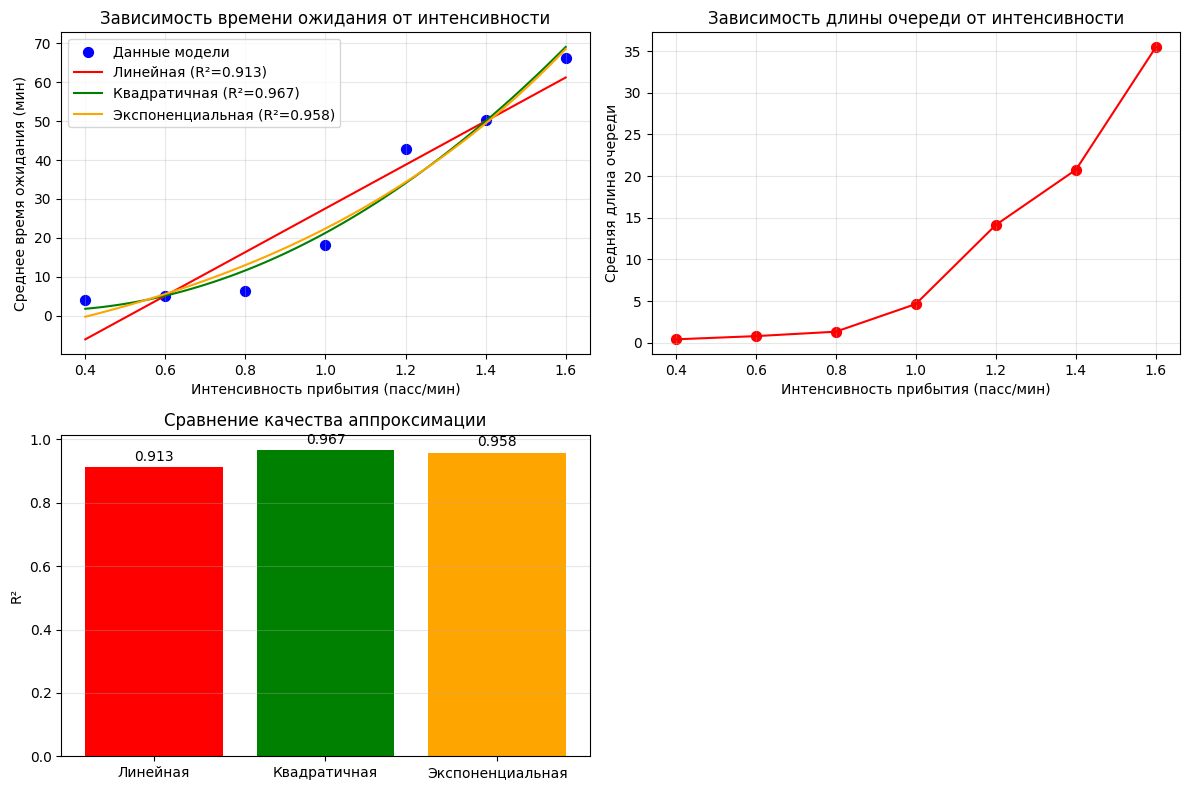


Лучшая модель аппроксимации: Квадратичная

ЗАДАЧА 2: АНАЛИЗ ОТКАЗА РЕСУРСОВ (КАСС)
Анализ устойчивости системы при уменьшении количества касс:
  Касс работает: 6/6, ожидание=5.33, пропускная=0.934 -> СТАБИЛЬНА
  Касс работает: 5/6, ожидание=6.75, пропускная=0.966 -> СТАБИЛЬНА
  Касс работает: 4/6, ожидание=19.12, пропускная=0.972 -> СТАБИЛЬНА
  Касс работает: 3/6, ожидание=53.12, пропускная=0.766 -> НЕСТАБИЛЬНА
  Касс работает: 2/6, ожидание=96.34, пропускная=0.509 -> НЕСТАБИЛЬНА
  Касс работает: 1/6, ожидание=173.72, пропускная=0.253 -> НЕСТАБИЛЬНА


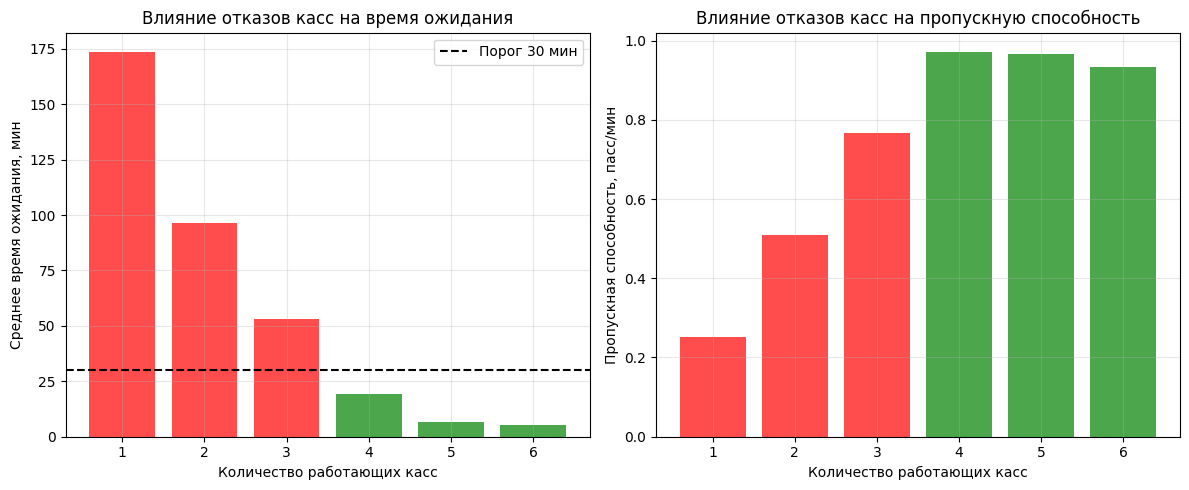


Максимальное количество отказавших касс, при котором система стабильна: 2

ЗАДАЧА 3: СРАВНЕНИЕ АЛЬТЕРНАТИВ
  Базовая: ожидание=17.96 ± 4.95, пропускная=0.966, очередь=4.57
  Больше касс: ожидание=6.85 ± 1.00, пропускная=0.966, очередь=1.42
  Быстрее обслуживание: ожидание=6.92 ± 0.86, пропускная=0.971, очередь=1.76
  Снижение потока: ожидание=6.29 ± 0.78, пропускная=0.781, очередь=1.34


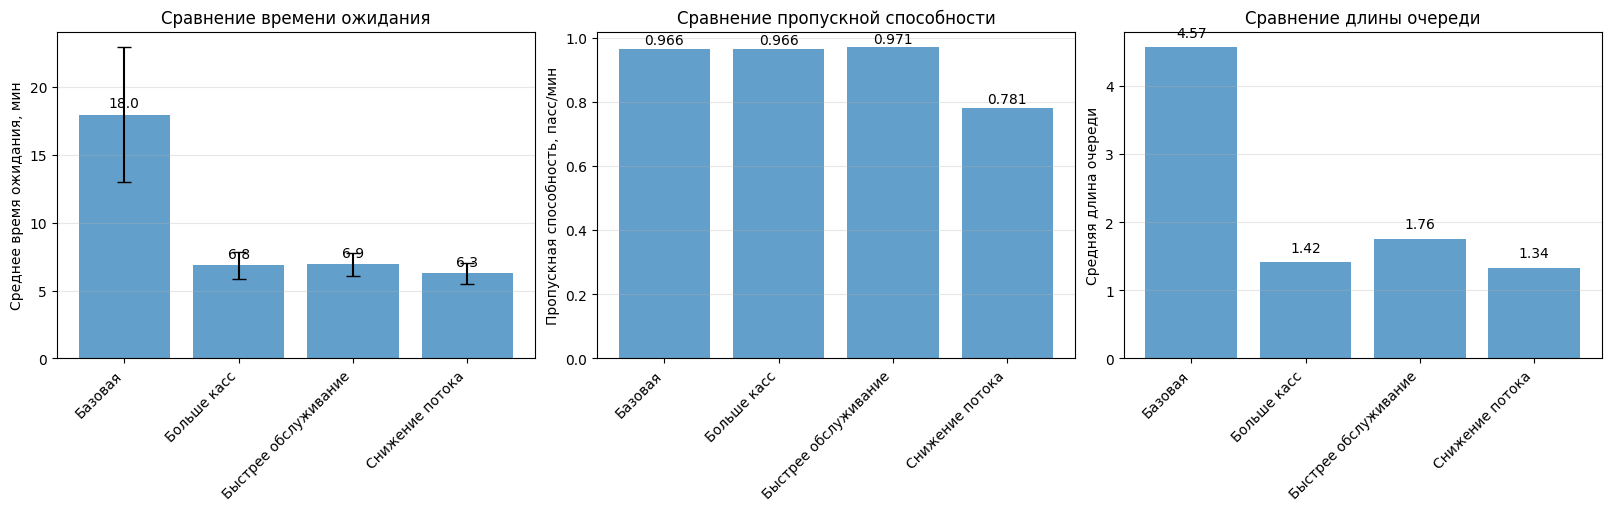


Лучшая альтернатива по времени ожидания: Снижение потока (6.29 мин)

ЗАДАЧА 4: ДВУХФАКТОРНЫЙ ЭКСПЕРИМЕНТ
  num_booths=3, arrival_rate=0.60 -> ожидание=7.46
  num_booths=3, arrival_rate=0.80 -> ожидание=21.44
  num_booths=3, arrival_rate=1.00 -> ожидание=53.12
  num_booths=3, arrival_rate=1.20 -> ожидание=82.09
  num_booths=3, arrival_rate=1.40 -> ожидание=79.54
  num_booths=4, arrival_rate=0.60 -> ожидание=5.16
  num_booths=4, arrival_rate=0.80 -> ожидание=6.57
  num_booths=4, arrival_rate=1.00 -> ожидание=19.12
  num_booths=4, arrival_rate=1.20 -> ожидание=42.73
  num_booths=4, arrival_rate=1.40 -> ожидание=49.13
  num_booths=5, arrival_rate=0.60 -> ожидание=3.97
  num_booths=5, arrival_rate=0.80 -> ожидание=6.18
  num_booths=5, arrival_rate=1.00 -> ожидание=6.75
  num_booths=5, arrival_rate=1.20 -> ожидание=13.23
  num_booths=5, arrival_rate=1.40 -> ожидание=29.85

Вариация от количества касс: 43.7%
Вариация от интенсивности прибытия: 56.3%
Более значимый фактор: интенсивность прибы

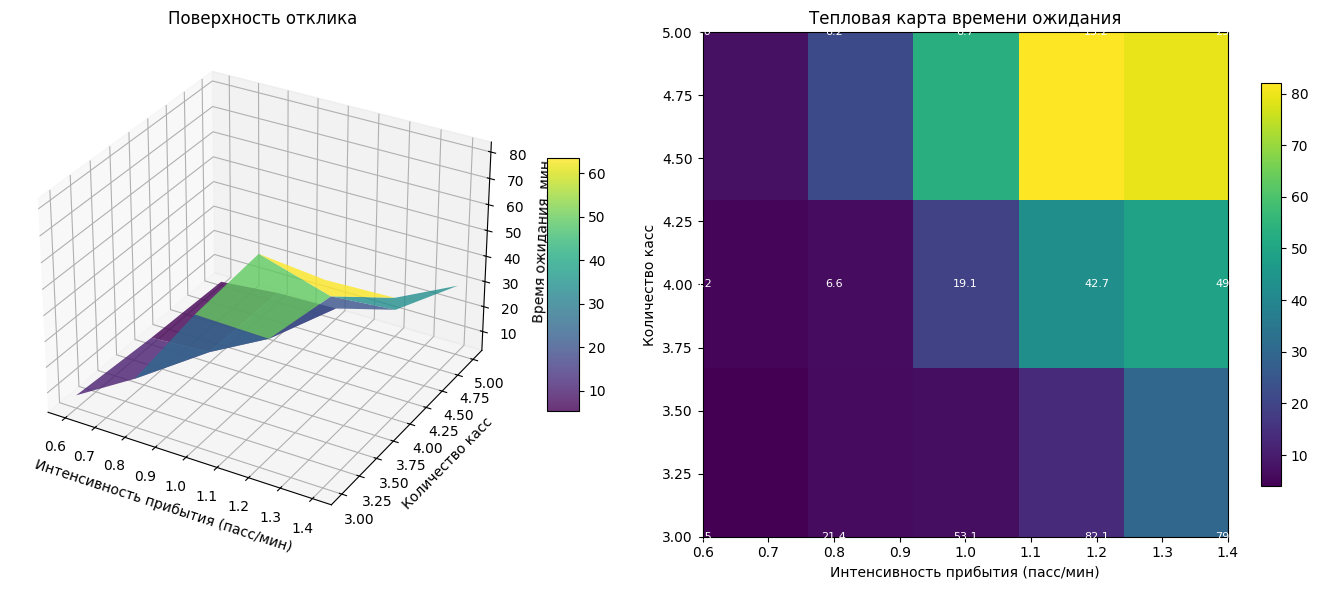


СВОДКА РЕЗУЛЬТАТОВ ЛАБОРАТОРНОЙ РАБОТЫ №4
1. Аппроксимация зависимости: лучшая модель — Квадратичная
2. Устойчивость к отказам: система выдерживает до 2 отказавших касс
3. Лучшая альтернатива: Снижение потока (ожидание 6.29 мин)
4. Двухфакторный эксперимент:
   - Влияние количества касс: 43.7%
   - Влияние интенсивности прибытия: 56.3%


In [4]:
# Запуск всех экспериментов (как в Lab4-1)

controller = ExperimentController()
controller.run_all_experiments()
